# System Manipulation
We here illustrate some operations that can be performed on a system while building it.


In [1]:
# Let's start from the system we have manipulated above:
system_spec="""
- 'O': [2.3229430273, 1.3229430273, 1.7139430273]
  'frag': ['WAT', '0']
- 'H': [2.3229430273, 2.0801430273, 1.1274430273]
  'frag': ['WAT', '0']
- 'H': [2.3229430273, 0.5657430273000001, 1.1274430273]
  'frag': ['WAT', '0']
- 'O': [0.6147151365000005, 0.9319430273000001, 1.3229430272999996]
  'frag': ['WAT', '1']
- 'H': [0.6147151365000005, 1.5184430273000002, 2.0801430272999997]
  'frag': ['WAT', '1']
- 'H': [0.6147151365000005, 1.5184430273000002, 0.5657430272999997]
  'frag': ['WAT', '1']
"""

In [2]:
from BigDFT.Systems import system_from_dict_positions
from yaml import load, Loader
posinp=load(system_spec,Loader=Loader)
sys=system_from_dict_positions(posinp,units='angstroem')

## File I/O
You don't necessarily want to build systems every time, maybe you already have a file somewhere. For this purpose, we have the I/O module. We'll start with writing files as a demonstration.

In [3]:

from BigDFT.IO import write_pdb
from os.path import join

with open(join("scratch", "test.pdb"), "w") as ofile:
    write_pdb(sys, ofile)

In [4]:
with open(join("scratch", "test.pdb")) as ifile:
    print("".join([x for x in ifile]))

HETATM    1 O    WAT A   0       2.323   1.323   1.714  1.00  0.00       B   O  
HETATM    2 H    WAT A   0       2.323   2.080   1.127  1.00  0.00       B   H  
HETATM    3 H    WAT A   0       2.323   0.566   1.127  1.00  0.00       B   H  
HETATM    4 O    WAT A   1       0.615   0.932   1.323  1.00  0.00       B   O  
HETATM    5 H    WAT A   1       0.615   1.518   2.080  1.00  0.00       B   H  
HETATM    6 H    WAT A   1       0.615   1.518   0.566  1.00  0.00       B   H  



This pdb file is a justification for our fragment naming convention: the fragment IDs and names have been written as residue information.

Reading is of course the opposite process.

In [5]:
from BigDFT.IO import read_pdb
with open(join("scratch", "test.pdb")) as ifile:
    sys2 = read_pdb(ifile)

We provide support for a few different file types (mol2, pdb, xyz), but this is not comphrensive. Fortunately, with python there is always some other library available to do what we want to do, such as [OpenBabel](http://openbabel.org/wiki/Main_Page).

In [6]:
from BigDFT.Interop.BabelInterop import convert_system_to_babel
bsys = convert_system_to_babel(sys)

In [7]:
from openbabel.openbabel import OBConversion
conv = OBConversion()
conv.SetOutFormat("mol")
with open(join("scratch", "test.mol"), "w") as ofile:
    ofile.write(conv.WriteString(bsys))

In [8]:
with open(join("scratch", "test.mol")) as ifile:
    print("".join([x for x in ifile]))


 OpenBabel09042215063D

  6  4  0  0  0  0  0  0  0  0999 V2000
    2.3230    1.3230    1.7140 O   0  0  0  0  0  0  0  0  0  0  0  0
    2.3230    2.0800    1.1270 H   0  0  0  0  0  0  0  0  0  0  0  0
    2.3230    0.5660    1.1270 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.6150    0.9320    1.3230 O   0  0  0  0  0  0  0  0  0  0  0  0
    0.6150    1.5180    2.0800 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.6150    1.5180    0.5660 H   0  0  0  0  0  0  0  0  0  0  0  0
  2  1  1  0  0  0  0
  3  1  1  0  0  0  0
  4  5  1  0  0  0  0
  6  4  1  0  0  0  0
M  END



In [9]:
from openbabel.openbabel import OBMol
from BigDFT.Interop.BabelInterop import convert_babel_to_system

conv.SetInFormat("mol")
bsys2 = OBMol()
conv.ReadFile(bsys2, join("scratch", "test.mol"))
sys2 = convert_babel_to_system(bsys2)

The only downside to this back and forth process is that openbabel has forgotten our original fragmentation (data which is not stored in a `mol` file). We might notice that we've picked up some other `Atom` properties though.

In [10]:
for fragid, frag in sys2.items():
    print(fragid)
    for at in frag:
        print(dict(at))

HOH1:1
{'O': [2.323, 1.323, 1.714], 'units': 'angstroem', 'q0': [-0.4105], 'name': 'O.3'}
HOH0:0
{'H': [2.323, 2.08, 1.127], 'units': 'angstroem', 'q0': [0.2052], 'name': 'H'}
{'H': [2.323, 0.566, 1.127], 'units': 'angstroem', 'q0': [0.2052], 'name': 'H'}
{'H': [0.615, 1.518, 2.08], 'units': 'angstroem', 'q0': [0.2052], 'name': 'H'}
{'H': [0.615, 1.518, 0.566], 'units': 'angstroem', 'q0': [0.2052], 'name': 'H'}
HOH2:2
{'O': [0.615, 0.932, 1.323], 'units': 'angstroem', 'q0': [-0.4105], 'name': 'O.3'}


## Connectivity Matrix
One nice side effect of using openbabel is that it automatically detects the bonds that exist in our molecule. And since we read that information in from the file, we now have access to it in our BigDFT `System`.

In [11]:
print(sys2.conmat)

{'HOH1:1': [{('HOH0:0', 0): 1.0, ('HOH0:0', 1): 1.0}], 'HOH0:0': [{('HOH1:1', 0): 1.0}, {('HOH1:1', 0): 1.0}, {('HOH2:2', 0): 1.0}, {('HOH2:2', 0): 1.0}], 'HOH2:2': [{('HOH0:0', 2): 1.0, ('HOH0:0', 3): 1.0}]}


As I mentioned before, OpenBabel has spoiled our original fragmentation. So let's copy this bonding information back to our original system.

In [12]:
from BigDFT.Systems import copy_bonding_information
copy_bonding_information(sys2, sys)

The connectivity matrix is itself a `dict`. Let's iterate over it.

In [13]:
for fragid, atm_list in sys.conmat.items(): # For each fragment in the system
    print("Fragment:", fragid)
    for i, bond_list in enumerate(atm_list): # For each atm in a given fragment there are a list of bonds
        print("\tAtom:", i)
        for bond, order in bond_list.items():
            print("\t\tFragment:", bond[0], ", Atom Number:", bond[1], ", Bond Order:", order)

Fragment: WAT:0
	Atom: 0
		Fragment: WAT:0 , Atom Number: 1 , Bond Order: 1.0
		Fragment: WAT:0 , Atom Number: 2 , Bond Order: 1.0
	Atom: 1
		Fragment: WAT:0 , Atom Number: 0 , Bond Order: 1.0
	Atom: 2
		Fragment: WAT:0 , Atom Number: 0 , Bond Order: 1.0
Fragment: WAT:1
	Atom: 0
		Fragment: WAT:1 , Atom Number: 1 , Bond Order: 1.0
		Fragment: WAT:1 , Atom Number: 2 , Bond Order: 1.0
	Atom: 1
		Fragment: WAT:1 , Atom Number: 0 , Bond Order: 1.0
	Atom: 2
		Fragment: WAT:1 , Atom Number: 0 , Bond Order: 1.0


We might consider generating a connectivity matrix that can be visualized with matplotlib. To that, we'll have to first assign an index to each of our atoms.

In [14]:
indices = {}
i = 0
for fragid, frag in sys.items():
    for j, at in enumerate(frag):
        indices[(fragid, j)] = i
        i += 1

In [15]:
print(indices)

{('WAT:0', 0): 0, ('WAT:0', 1): 1, ('WAT:0', 2): 2, ('WAT:1', 0): 3, ('WAT:1', 1): 4, ('WAT:1', 2): 5}


Now construct the matrix.

In [16]:
from numpy import zeros

N = sum([len(x) for x in sys.values()])  # Number of atoms in a system
matrix = zeros((N, N))
for fragid, atm_list in sys.conmat.items():
    for i, bond_list in enumerate(atm_list):
        idx_i = indices[(fragid, i)]
        for bond, order in bond_list.items():
            idx_j = indices[bond]
            matrix[idx_i, idx_j] = order

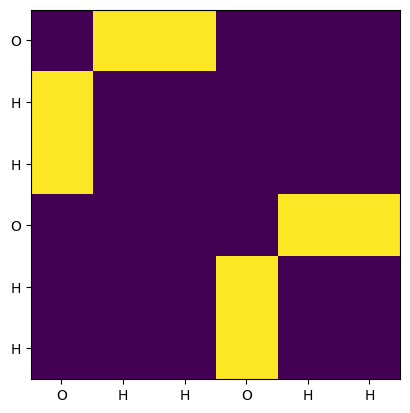

In [17]:
# NBVAL_IGNORE_OUTPUT
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 1)
axs.imshow(matrix)
symlist = []
for frag in sys.values():
    for at in frag:
        symlist.append(at.sym)
axs.set_xticks(range(N))
axs.set_xticklabels(symlist)
axs.set_yticks(range(N))
_ = axs.set_yticklabels(symlist)

## Illustrative Example: Fragments from connectivity Mattrix
Let's try to do something a little complicated to fit this all together. Let's consider the molecule Dapsone as a target of study.

In [18]:
pdb_string = """AUTHOR    GENERATED BY OPEN BABEL 3.1.0
HETATM    1  S   UNL     1      -0.002   1.619   0.000  1.00  0.00           S  
HETATM    2  O   UNL     1      -0.024   2.350  -1.259  1.00  0.00           O  
HETATM    3  O   UNL     1       0.061   2.349   1.260  1.00  0.00           O  
HETATM    4  N   UNL     1      -4.831  -1.851   0.004  1.00  0.00           N  
HETATM    5  N   UNL     1       4.821  -1.858  -0.004  1.00  0.00           N  
HETATM    6  C   UNL     1      -1.420   0.600   0.002  1.00  0.00           C  
HETATM    7  C   UNL     1       1.435   0.582  -0.001  1.00  0.00           C  
HETATM    8  C   UNL     1      -1.985   0.193   1.210  1.00  0.00           C  
HETATM    9  C   UNL     1       1.978   0.190  -1.210  1.00  0.00           C  
HETATM   10  C   UNL     1      -1.988   0.193  -1.206  1.00  0.00           C  
HETATM   11  C   UNL     1       1.980   0.190   1.206  1.00  0.00           C  
HETATM   12  C   UNL     1      -3.118  -0.621   1.211  1.00  0.00           C  
HETATM   13  C   UNL     1       3.110  -0.626  -1.211  1.00  0.00           C  
HETATM   14  C   UNL     1      -3.120  -0.621  -1.205  1.00  0.00           C  
HETATM   15  C   UNL     1       3.112  -0.626   1.205  1.00  0.00           C  
HETATM   16  C   UNL     1      -3.686  -1.028   0.003  1.00  0.00           C  
HETATM   17  C   UNL     1       3.677  -1.034  -0.003  1.00  0.00           C  
HETATM   18  H   UNL     1      -1.556   0.493   2.162  1.00  0.00           H  
HETATM   19  H   UNL     1       1.547   0.491  -2.159  1.00  0.00           H  
HETATM   20  H   UNL     1      -1.561   0.491  -2.160  1.00  0.00           H  
HETATM   21  H   UNL     1       1.551   0.488   2.157  1.00  0.00           H  
HETATM   22  H   UNL     1      -3.549  -0.933   2.159  1.00  0.00           H  
HETATM   23  H   UNL     1       3.539  -0.939  -2.159  1.00  0.00           H  
HETATM   24  H   UNL     1      -3.552  -0.932  -2.153  1.00  0.00           H  
HETATM   25  H   UNL     1       3.543  -0.939   2.153  1.00  0.00           H  
HETATM   26  H   UNL     1      -5.242  -2.146   0.880  1.00  0.00           H  
HETATM   27  H   UNL     1      -5.244  -2.145  -0.871  1.00  0.00           H  
HETATM   28  H   UNL     1       5.230  -2.155  -0.880  1.00  0.00           H  
HETATM   29  H   UNL     1       5.232  -2.155   0.871  1.00  0.00           H  
CONECT    1    2    2    3    3                                       
CONECT    1    6    7                                                 
CONECT    2    1    1                                                 
CONECT    3    1    1                                                 
CONECT    4   16   26   27                                            
CONECT    5   17   28   29                                            
CONECT    6    1    8    8   10                                       
CONECT    7    1    9    9   11                                       
CONECT    8    6    6   12   18                                       
CONECT    9    7    7   13   19                                       
CONECT   10    6   14   14   20                                       
CONECT   11    7   15   15   21                                       
CONECT   12    8   16   16   22                                       
CONECT   13    9   17   17   23                                       
CONECT   14   10   10   16   24                                       
CONECT   15   11   11   17   25                                       
CONECT   16    4   12   12   14                                       
CONECT   17    5   13   13   15                                       
CONECT   18    8                                                      
CONECT   19    9                                                      
CONECT   20   10                                                      
CONECT   21   11                                                      
CONECT   22   12                                                      
CONECT   23   13                                                      
CONECT   24   14                                                      
CONECT   25   15                                                      
CONECT   26    4                                                      
CONECT   27    4                                                      
CONECT   28    5                                                      
CONECT   29    5                                                      
MASTER        0    0    0    0    0    0    0    0   29    0   29    0
END
"""

Read it in from file.

In [19]:
from io import StringIO
sys = read_pdb(StringIO(pdb_string))

In [20]:
# NBVAL_IGNORE_OUTPUT
sys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

We want to partition it into three fragments, one for each of the rings and one for the connecting SO2. 

In [21]:
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment
splitsys = System()
splitsys["CON:0"] = Fragment()
splitsys["RIN:1"] = Fragment()
splitsys["RIN:2"] = Fragment()

How can we do this automatically? One way is to follow the connectivity matrix in a depth first manner, assigning atoms as we go.

In [22]:
# There is only one fragment, what is it's name?
key = list(sys)[0]
# Which atom is the sulfur?
sidx = [i for i, at in enumerate(sys[key]) if at.sym == "S"][0]

splitsys["CON:0"].append(sys[key][sidx])

# For bond connected to sulfur
stack_rin = {"RIN:1": [], "RIN:2": []}
stack_rin_2 = []
for _, aidx in sys.conmat[key][sidx]:
    atm = sys[key][aidx]
    if atm.sym == "O":
        splitsys["CON:0"].append(atm)
    elif len(stack_rin["RIN:1"]) == 0:
        stack_rin["RIN:1"].append(aidx)
    else:
        stack_rin["RIN:2"].append(aidx)

We've created the connecting fragments, so now we just follow the bonds on each of the rings.

In [23]:
for fid, stack in stack_rin.items():
    processed = []
    while(len(stack) > 0): 
        aidx = stack.pop(0)
        processed.append(aidx)
        atm = sys[key][aidx]
        if atm.sym == "S":
            continue
        splitsys[fid].append(atm)

        for _, link in sys.conmat[key][aidx]:
            if link not in processed:
                stack.append(link)

In [24]:
# NBVAL_IGNORE_OUTPUT
splitsys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

With the system split, our next goal is to explore the effect of bending the rings. We can think of that as rotating both rings about an axis which is sticking out of the sulfur, and has the same direction as a vector going through the two oxygens.

In [25]:
axis_center = splitsys["CON:0"][0].get_position()
axis_vector = [x - y for x, y in zip(splitsys["CON:0"][1].get_position(), 
                                     splitsys["CON:0"][2].get_position())]

In [26]:
from copy import deepcopy
systems = {}
for angle in range(0, 46, 5):
    systems[angle] = deepcopy(splitsys)
    systems[angle]["RIN:1"].rotate_on_axis(angle=angle, axis=axis_vector, 
                                           centroid=axis_center, units="degrees")

To check, we want to draw each of the systems we created superimposed on each other. This can be done by exploiting the `show` option to `display_system`.

In [27]:
# NBVAL_IGNORE_OUTPUT
from BigDFT.Visualization import InlineVisualizer
viz = InlineVisualizer(400,300)
for a, sys in systems.items():
    viz.display_system(sys, show=(a == 45))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol